<a id="top"></a>
# GIF Notebook

<hr>

# Notebook Summary

This notebook shows how to generate an animated GIF of data through time.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#import)
* [Choose Platform and Product](#plat_prod)
* [Get the Extents of the Cube](#extents)
* [Define the Extents of the Analysis](#define_extents)
* [Load Data from the Data Cube](#load_data)
* [Generate Animated RGB GIF](#generate_rgb_gif)
* [Generate Animated Spectral Index GIF](#generate_spec_ind_gif)

## <span id="import">Import Dependencies and Connect to the Data Cube [&#9652;](#top)</span>

In [1]:
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import matplotlib.pyplot as plt
import numpy as np  
import xarray as xr
import matplotlib
import utils.data_cube_utilities.data_access_api as dc_api
import os

api = dc_api.DataAccessApi()
dc = api.dc

/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages/psycopg2-2.7.6.1-py3.6-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## <span id="plat_prod">Choose Platform and Product [&#9652;](#top)</span>

In [2]:
product = "ls8_lasrc_ghana"
platform = "LANDSAT_8"

## <span id="extents">Get the Extents of the Cube [&#9652;](#top)</span>

In [3]:
from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, (min_max_dates[0], min_max_dates[1]))))

Latitude Extents: (3.772924193304, 11.318772579912)
Longitude Extents: (-3.772924193304, 1.886462096652)
Time Extents: ['2013-04-13', '2019-02-16']


## <span id="define_extents">Define the Extents of the Analysis [&#9652;](#top)</span>

In [5]:
# Freetown, Sierra Leone - 2015 to 2018 timelapse.
lat = (5.4400, 5.6300)
lon = (-0.4669, -0.3200)
time_extents = ('2016-01-01', '2018-12-31')

**Visualize the selected area**

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(lat, lon)

## <span id="load_data">Load Data from the Data Cube [&#9652;](#top)</span>

In [7]:
data = dc.load(platform=platform, product=product, 
               lat=lat, lon=lon, 
               time=time_extents,
               group_by='solar_day')

In [8]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid

def get_landsat_clean_mask_full(dataset, platform, no_data=-9999):
    """
    Returns a boolean mask denoting points in `dataset`
    which are clean according to (1) abscense of clouds according to 
    the pixel_qa band in `dataset`, (2) the `no_data` value, and 
    (3) the valid range of values for Landsat (0-10000).
    """
    cloud_mask = landsat_qa_clean_mask(dataset, platform=platform)
    no_data_mask = (dataset != no_data).to_array().all('variable')
    invalid_mask = landsat_clean_mask_invalid(dataset)
    return cloud_mask & no_data_mask & invalid_mask

# Remove cloud pixels and make them appear black.
clean_mask = get_landsat_clean_mask_full(data, platform)

## <span id="generate_rgb_gif">Generate Animated RGB GIF [&#9652;](#top)</span>

In [9]:
## Settings ##

# The names of the data arrays in `data` that are used as the 
# red, green, and blue channels of the output GIF, in that order.
gif_rgb_channels = ['nir', 'swir1', 'swir2']

# Whether or not to remove clouds from the image.
remove_clouds = False

## End Settings ##

Generating 50 frame animation
    Exporting animation to output/gifs/rgb.gif


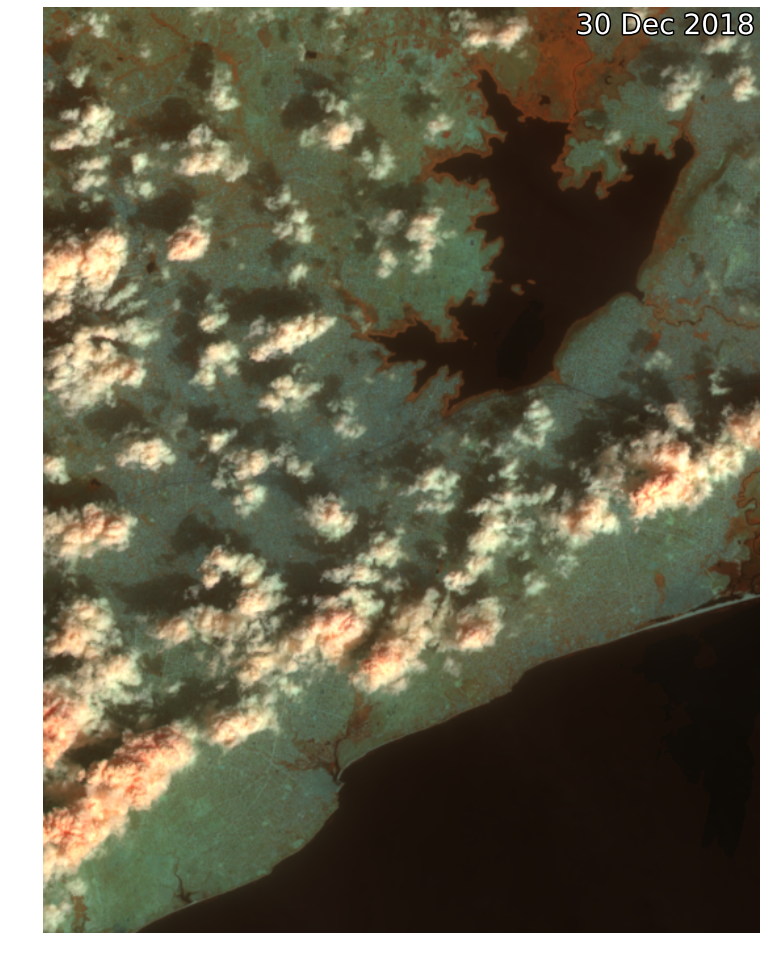

In [10]:
from utils_special.data_cube_utilities.plotter_utils import animated_timeseries

if remove_clouds:
    plotting_data = data[gif_rgb_channels].where(clean_mask)
else:
    plotting_data = data[gif_rgb_channels]

output_dir = 'output/gifs'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
# The names of the data arrays in data that are used as the 
# red, green, and blue channels of the output GIF, in that order.
# The `interval` parameter sets the number of milliseconds between frames.
# The `width_pixels` parameter sets the width of the GIF in pixels.
# The height of the GIF in pixels is determined by this and the original
# data's shape (aspect ratio is preserved).
# See the documentation of this function for more information.
animated_timeseries(plotting_data, bands=gif_rgb_channels, 
                    output_path=output_dir+"/rgb.gif", 
                    interval=500, width_pixels=350,
                    x_dim='longitude', y_dim='latitude')

del plotting_data # Free memory.

## <span id="generate_spec_ind_gif">Generate Animated Spectral Index GIF [&#9652;](#top)</span>

**Clouds will be removed.**

In [11]:
## Settings ##

# The spectral index to generate a GIF for.
spectral_index = 'NDVI'

## End Settings ##

acceptable_spectral_indicies = ['NDVI', 'NDBI', 'NDWI', 'EVI', 'SAVI']
assert spectral_index in acceptable_spectral_indicies, \
    f"The `spectral_index` variable must be one of {acceptable_spectral_indicies}"

In [12]:
from utils_special.data_cube_utilities.vegetation import NDVI, EVI, SAVI
from utils_special.data_cube_utilities.urbanization import NDBI
from utils_special.data_cube_utilities.dc_water_classifier import NDWI

spec_ind_func = {
    'NDVI': NDVI,
    'NDBI': NDBI,
    'NDWI': NDWI,
    'EVI': EVI,
    'SAVI': SAVI
}

data[spectral_index] = spec_ind_func[spectral_index](data)

/home/localuser/Datacube/datacube_env/lib/python3.6/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Generating 50 frame animation
    Exporting animation to output/gifs/NDVI.gif


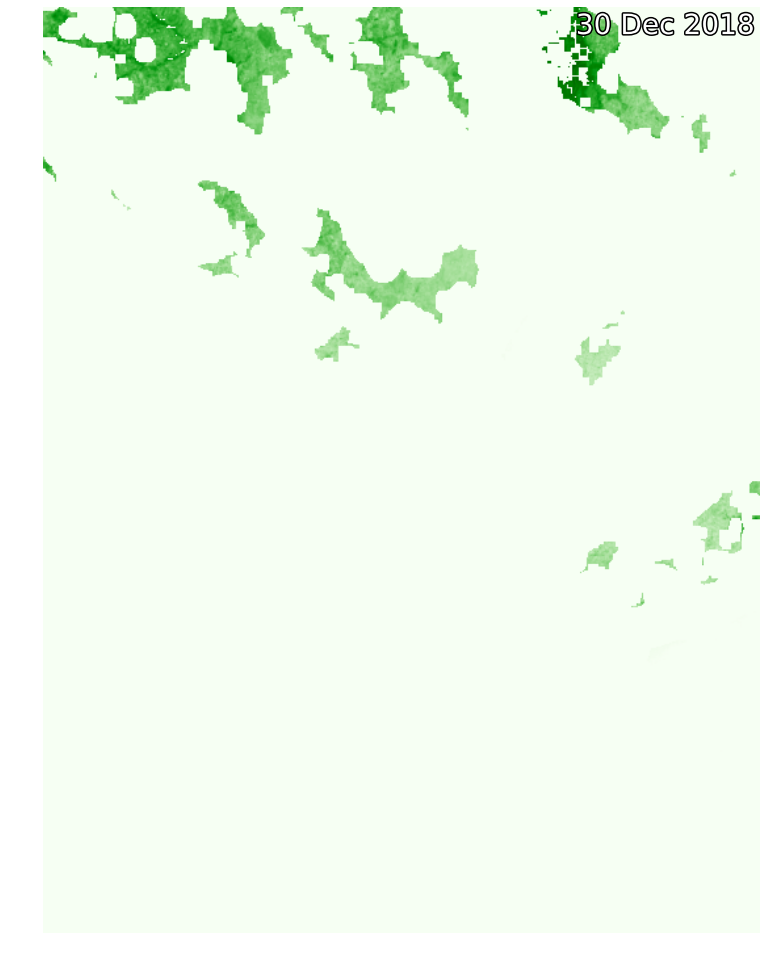

In [13]:
plotting_data = data[[spectral_index]].where(clean_mask)

# Get RGB values for the spectral index given a colormap `cmap`.
cmap = matplotlib.cm.get_cmap('Greens')
spectral_index_rgba_arr = cmap(plotting_data[spectral_index].values)
common_coords_dims_kwargs = dict(coords=plotting_data[spectral_index].coords, dims=plotting_data[spectral_index].dims)
spectral_index_channel_names = [f"{spectral_index}_red", f"{spectral_index}_green", f"{spectral_index}_blue"]
plotting_data[spectral_index_channel_names[0]] = xr.DataArray(spectral_index_rgba_arr[:,:,:,0], **common_coords_dims_kwargs)
plotting_data[spectral_index_channel_names[1]] = xr.DataArray(spectral_index_rgba_arr[:,:,:,1], **common_coords_dims_kwargs)
plotting_data[spectral_index_channel_names[2]] = xr.DataArray(spectral_index_rgba_arr[:,:,:,2], **common_coords_dims_kwargs)

output_dir = 'output/gifs'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
# The names of the data arrays in data that are used as the 
# red, green, and blue channels of the output GIF, in that order.
# The `interval` parameter sets the number of milliseconds between frames.
# The `width_pixels` parameter sets the width of the GIF in pixels.
# The height of the GIF in pixels is determined by this and the original
# data's shape (aspect ratio is preserved).
# See the documentation of this function for more information.
animated_timeseries(plotting_data, bands=spectral_index_channel_names, 
                    output_path=output_dir+f"/{spectral_index}.gif", 
                    interval=500, width_pixels=350,
                    x_dim='longitude', y_dim='latitude')

In [14]:
!ls -lah output/gifs/*.gif

-rw-rw-r-- 1 localuser localuser 1.9M Dec  5 18:52 output/gifs/NDVI.gif
-rw-rw-r-- 1 localuser localuser 5.9M Dec  5 18:51 output/gifs/rgb.gif
-rw-rw-r-- 1 localuser localuser 743K Dec  3 18:50 output/gifs/test.gif
-rw-rw-r-- 1 localuser localuser  11M Dec  3 18:22 output/gifs/test_tanz.gif
